# **Dataset 4: Open University**

In this notebook we'll go through the entire process of exploratory data analysis, synthetic data generation (SDG) and evaluation for Dataset 4: Open University.

The evaluation approach that is used was suggested by  Liu et al. [1]. The goal is to provide a comprehensive evaluation for synthetic tabular data in learning analytics that encompasses utility, resemblance and privacy metrics.

The dataset used in this notebook is part of OULAD - a large anonymised dataset from the Open University for learning analytics purposes, that contains data about students, courses and interactions [2]. Here, the *studentInfo.csv* file is used, since it provides a suitable number of variables for utility evaluation. It contains 32594 entries and is by far the largest dataset used in this project.

Dataset source: https://analyse.kmi.open.ac.uk/open-dataset

**References:**

[1] Qinyi Liu, Mohammad Khalil, Ronas Shakya, and Jelena Jovanovic. 2024.
Scaling While Privacy Preserving: A Comprehensive Synthetic Tabular
Data Generation and Evaluation in Learning Analytics. In The 14th Learning
Analytics and Knowledge Conference (LAK ’24), March 18–22, 2024, Kyoto,
Japan. ACM, New York, NY, USA, 12 pages. https://doi.org/10.1145/3636555.
3636921

[2] Kuzilek J., Hlosta M., Zdrahal Z. Open University Learning Analytics dataset Sci. Data 4:170171 doi: 10.1038/sdata.2017.171 (2017).

### **Import Packages**


In [23]:
import os
import sys
import multiprocessing
import subprocess
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

sys.path.append(os.path.abspath("../src"))

from generation.data_synthesizer import ds_generate_data
from generation.synthetic_data_vault import sdv_generate_data
from evaluation.utility import run_utility_eval
from evaluation.resemblance import pairwise_correlation_diff, jsd, wd
from evaluation.privacy import dcr, nndr, mia


## **Exploratory Data Analysis**

In [24]:
# Load dataset as dataframe
data_path = "../data/original_data/4_open_university/4_open_university.csv"
original_data = pd.read_csv(data_path)
original_data.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [25]:
# Get general information about the dataset
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
 11  final_result          32593 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.0+ MB


In [26]:
# Check for missing values
original_data.isnull().sum()

code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64

Found 1111 missing values in column 'imd_band'. Replace with mode.

In [27]:
original_data["imd_band"].fillna(original_data["imd_band"].mode()[0], inplace=True)
original_data.isnull().sum()

code_module             0
code_presentation       0
id_student              0
gender                  0
region                  0
highest_education       0
imd_band                0
age_band                0
num_of_prev_attempts    0
studied_credits         0
disability              0
final_result            0
dtype: int64

<Axes: xlabel='final_result', ylabel='Count'>

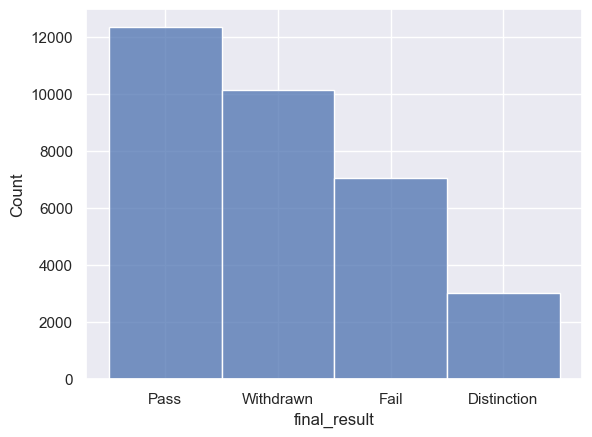

In [28]:
# Check score distribution
sns.histplot(original_data['final_result'])

In [29]:
# Check categorical columns
categorical_cols = original_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(col, original_data[col].unique())

code_module ['AAA' 'BBB' 'CCC' 'DDD' 'EEE' 'FFF' 'GGG']
code_presentation ['2013J' '2014J' '2013B' '2014B']
gender ['M' 'F']
region ['East Anglian Region' 'Scotland' 'North Western Region'
 'South East Region' 'West Midlands Region' 'Wales' 'North Region'
 'South Region' 'Ireland' 'South West Region' 'East Midlands Region'
 'Yorkshire Region' 'London Region']
highest_education ['HE Qualification' 'A Level or Equivalent' 'Lower Than A Level'
 'Post Graduate Qualification' 'No Formal quals']
imd_band ['90-100%' '20-30%' '30-40%' '50-60%' '80-90%' '70-80%' '60-70%' '40-50%'
 '10-20' '0-10%']
age_band ['55<=' '35-55' '0-35']
disability ['N' 'Y']
final_result ['Pass' 'Withdrawn' 'Fail' 'Distinction']


In [30]:
# Replace certrain characters to make it work with DataSynthesizer
to_replace = {'-':' to ', '55<=': '55 to 100'}
original_data['age_band'].replace(to_replace=to_replace, regex=True, inplace=True)

# replace % character in imd_band column
original_data['imd_band'].replace('%', 'pct', regex=True, inplace=True)
original_data.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100pct,55 to 100,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30pct,35 to 55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40pct,35 to 55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60pct,35 to 55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60pct,0 to 35,0,60,N,Pass


## **Synthetic Data Generation**

In [31]:
original_data_path = "../data/original_data/4_open_university/"
train_file = os.path.join(original_data_path, "train_data.csv")
test_file = os.path.join(original_data_path, "test_data.csv")

# Prüfen, ob beide Dateien existieren
if os.path.isfile(train_file) and os.path.isfile(test_file):
    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)
    print("Train and test data loaded.")
else:
    train_data, test_data = train_test_split(original_data, test_size=0.3, random_state=42)
    train_data.to_csv(train_file, index=False)
    test_data.to_csv(test_file, index=False)
    print("Train and test data saved.")

Train and test data loaded.


In [32]:
# Set the start method of the multiprocessing module to 'fork' to avoid an error
multiprocessing.set_start_method('fork', force=True)

synth_path = "../data/synthetic_data/4_open_university/"
dataset_name = "4_open_university"
csv_files = [file for file in os.listdir(synth_path) if file.endswith(".csv")]

# Number of samples to generate
n = len(train_data)

if len(csv_files) == 0:
    # Use train_data.csv to fit SDG models and generate synthetic data
    data_path = original_data_path + "train_data.csv"
    arguments = [data_path, str(n), dataset_name]

    print("Sampling synthpop...")
    result = subprocess.run(['Rscript', '../src/generation/synthpop.R',   *arguments], capture_output=True, text=True)

    print("Sampling DataSynthesizer...")
    ds_generate_data(data_path=data_path, num_samples=n, dataset_name=dataset_name)

    sdv_generate_data(data_path=data_path, num_samples=n, dataset_name=dataset_name)
else:
    print("Synthetic data already exists.")

Synthetic data already exists.


Encode all categorical columns of both original (train+test) data and synthetic data using label encoding

In [33]:
# Load the synthetic data as dataframe
synthpop = pd.read_csv(synth_path + "synthpop.csv")
ds = pd.read_csv(synth_path + "ds.csv")
tvae = pd.read_csv(synth_path + "tvae.csv")
gaussian_copula = pd.read_csv(synth_path + "gaussian_copula.csv")
copula_gan = pd.read_csv(synth_path + "copula_gan.csv")
ctgan = pd.read_csv(synth_path + "ctgan.csv")

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.fit_transform(test_data[col])

    synthpop[col] = le.fit_transform(synthpop[col])
    ds[col] = le.fit_transform(ds[col])
    tvae[col] = le.fit_transform(tvae[col])
    gaussian_copula[col] = le.fit_transform(gaussian_copula[col])
    copula_gan[col] = le.fit_transform(copula_gan[col])
    ctgan[col] = le.fit_transform(ctgan[col])

    label_encoders[col] = le

train_data.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,5,3,383602,0,8,2,8,0,0,120,0,2
1,3,0,503926,0,0,0,7,0,0,60,0,2
2,3,1,2671469,0,7,2,6,0,0,60,0,2
3,5,1,569474,1,12,2,3,1,0,60,0,2
4,5,3,654322,1,3,0,6,0,0,120,1,3


In [34]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22815 entries, 0 to 22814
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   code_module           22815 non-null  int64
 1   code_presentation     22815 non-null  int64
 2   id_student            22815 non-null  int64
 3   gender                22815 non-null  int64
 4   region                22815 non-null  int64
 5   highest_education     22815 non-null  int64
 6   imd_band              22815 non-null  int64
 7   age_band              22815 non-null  int64
 8   num_of_prev_attempts  22815 non-null  int64
 9   studied_credits       22815 non-null  int64
 10  disability            22815 non-null  int64
 11  final_result          22815 non-null  int64
dtypes: int64(12)
memory usage: 2.1 MB


In [35]:
ctgan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22815 entries, 0 to 22814
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   code_module           22815 non-null  int64
 1   code_presentation     22815 non-null  int64
 2   id_student            22815 non-null  int64
 3   gender                22815 non-null  int64
 4   region                22815 non-null  int64
 5   highest_education     22815 non-null  int64
 6   imd_band              22815 non-null  int64
 7   age_band              22815 non-null  int64
 8   num_of_prev_attempts  22815 non-null  int64
 9   studied_credits       22815 non-null  int64
 10  disability            22815 non-null  int64
 11  final_result          22815 non-null  int64
dtypes: int64(12)
memory usage: 2.1 MB


## **Evaluation**

In [36]:
synth_datasets = [synthpop, ds, tvae, gaussian_copula, copula_gan, ctgan]
model_names = ["synthpop", "ds", "tvae", "gaussian_copula", "copula_gan", "ctgan"]

### **Resemblance**

The resemblance dimension includes mutliple distance metrics to measure the similarity of the synthetic and real data: **Difference in pairwise correlation, Jensen-Shannon divergence, Wasserstein distance**

- **Difference in pairwise correlation** is used to measure how well feature-interactions are preserved within synthetic data. First the pairwise correlation matrices for each real and synthetic data is computed. Pearson correlation coefficient is used for continuous features ( [-1,1] range) and the Theil uncer-
tainty coefficient ([0,1] range) for categorical features
    - lower (difference) values are better
- **JSD** is a method for measuring similarity between two probability distributions. It is based on Kullback-Leibler divergence, but has several benefits like being symmetric and having finite values. Values are bounded between 0 and 1, where values close to 0 indicate high similarity and values close to 1 indicate almost no similarity between the distributions.
    - lower values are better
- **WD** is used to compare the distributions of two continuous/mixed variables, where one variable is derived from the other → how well the synthetic data emulates the distribution of the
individual variables
    - lower values are better


**Difference in pairwise correlation:**

In [37]:
corr_diff_df = pd.read_csv("../data/results/tables/corr_diff.csv")
rows = []

if (corr_diff_df["Dataset"] == 4).any():
    print("Entry for '4_open_university' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = pairwise_correlation_diff(train_data, synth_dataset)
        rows.append([4,model_names[i], result])

    rows = pd.DataFrame(rows, columns=corr_diff_df.columns)
    corr_diff_df = pd.concat([corr_diff_df, rows])
    corr_diff_df.to_csv("../data/results/tables/corr_diff.csv", index=False)
    
corr_diff_df.tail(6)

,Dataset,Model,Pairwise Corr Diff
0,4,synthpop,0.005884
1,4,ds,0.035256
2,4,tvae,0.025112
3,4,gaussian_copula,0.035348
4,4,copula_gan,0.030462
5,4,ctgan,0.029021


**Jensen-Shannon Divergence**

In [38]:
jsd_df = pd.read_csv("../data/results/tables/jsd.csv")
rows = []

if (jsd_df["Dataset"] == 4).any():
    print("Entry for '4_open_university' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = jsd(train_data, synth_dataset)
        rows.append([4,model_names[i], result])

    rows = pd.DataFrame(rows, columns=jsd_df.columns)
    jsd_df = pd.concat([jsd_df, rows])
    jsd_df.to_csv("../data/results/tables/jsd.csv", index=False)

jsd_df.tail(6)

,Dataset,Model,JSD Diff
0,4,synthpop,0.012889
1,4,ds,0.112649
2,4,tvae,0.075311
3,4,gaussian_copula,0.106737
4,4,copula_gan,0.074107
5,4,ctgan,0.065716


**Wasserstein Distance**

In [39]:
wd_df = pd.read_csv("../data/results/tables/wd.csv")
rows = []

if (wd_df["Dataset"] == 4).any():
    print("Entry for '4_open_university' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = wd(train_data, synth_dataset)
        rows.append([4,model_names[i], result])

    rows = pd.DataFrame(rows, columns=wd_df.columns)
    wd_df = pd.concat([wd_df, rows])
    wd_df.to_csv("../data/results/tables/wd.csv", index=False)
    
wd_df.tail(6)

,Dataset,Model,WD Diff
0,4,synthpop,0.001847
1,4,ds,0.016251
2,4,tvae,0.026468
3,4,gaussian_copula,0.004953
4,4,copula_gan,0.023060
5,4,ctgan,0.018926


In [40]:
from evaluation.sd_metrics import sd_metrics


for i, synth_dataset in enumerate(synth_datasets):
    print(f"Calculating metrics for {model_names[i]}...")
    print(sd_metrics(train_data, synth_dataset), "\n")

Calculating metrics for synthpop...
Property  Data Validity  Data Structure  Column Shapes  Column Pair Trends
Score               1.0             1.0       0.996022            0.975125 

Calculating metrics for ds...
Property  Data Validity  Data Structure  Column Shapes  Column Pair Trends
Score               1.0             1.0       0.918475            0.895741 

Calculating metrics for tvae...
Property  Data Validity  Data Structure  Column Shapes  Column Pair Trends
Score               1.0             1.0       0.910077            0.773109 

Calculating metrics for gaussian_copula...
Property  Data Validity  Data Structure  Column Shapes  Column Pair Trends
Score               1.0             1.0       0.936383            0.864823 

Calculating metrics for copula_gan...
Property  Data Validity  Data Structure  Column Shapes  Column Pair Trends
Score               1.0             1.0        0.92258            0.847593 

Calculating metrics for ctgan...
Property  Data Validity  Dat

### **Privacy**

To assess the privacy aspect of the synthetic data the metrics **Distance to closest Record (DCR)**, **Nearest Neighbour Difference Ratio (NNDR)** and **Membership Inference Attack (MIA)** will be used. 

- In **DCR** the euclidean distance between
each record in original and synthetic dataset is computed. DCR is the minimum distance between a synthetic record and a original record. 
    - A value of zero indicates that the synthetic record is an identical copy of the original one -> leak of real information, higher values indicate more privacy

- **NNDR** is ratio between nearest and second nearest real neighbour to any corresponding synthetic record (NNDR(s) = d1/d2) and is within [0,1]
    - higher values indicate better privacy

- **MIA** is used to assess the disclosure risk by assuming that an attacker has access to all the records of the synthetic data and to a random subset of the original data. Using a real record the attacker then tries to find the closest record in the synthetic dataset. If there is any distance below some threshold, the attacker can assume that the corresponding real record was used to generate the synthetic data.
    - For strong privacy preservation both accuracy and precision should be below 0.5 for all thresholds

**Distance to closest record (DCR)**

In [41]:
dcr_df = pd.read_csv("../data/results/tables/dcr.csv")
rows = []

if (dcr_df["Dataset"] == 4).any():
    print("Entry for '4_open_university' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = dcr(train_data, synth_dataset, model_names[i], dataset_name=dataset_name, save_hist=True)
        result_within_real = dcr(train_data, synth_dataset, model_names[i], dataset_name=dataset_name, within="Original", save_hist=True)
        result_within_synth = dcr(train_data, synth_dataset, model_names[i], dataset_name=dataset_name, within="Synthetic", save_hist=True)
        rows.append([4,model_names[i], result, result_within_real, result_within_synth])

    rows = pd.DataFrame(rows, columns=dcr_df.columns)
    dcr_df = pd.concat([dcr_df, rows])
    dcr_df.to_csv("../data/results/tables/dcr.csv", index=False)

dcr_df.tail(6)

,Dataset,Model,DCR 5th Percentile,DCR 5th Percentile (within Real),DCR 5th Percentile (within Synthetic)
0,4,synthpop,2.449,2.236,2.449
1,4,ds,10.536,2.236,9.798
2,4,tvae,5.831,2.236,5.000
3,4,gaussian_copula,13.038,2.236,12.166
4,4,copula_gan,6.164,2.236,5.477
5,4,ctgan,6.325,2.236,6.325


<Figure size 640x480 with 0 Axes>

**Nearest Neighbor distance ratio (NNDR)**

In [42]:
nndr_df = pd.read_csv("../data/results/tables/nndr.csv")
rows = []

if (nndr_df["Dataset"] == 4).any():
    print("Entry for '4_open_university' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = nndr(train_data, synth_dataset)
        result_within_real = nndr(train_data, synth_dataset, within="Original")
        result_within_synth = nndr(train_data, synth_dataset, within="Synthetic")
        rows.append([4,model_names[i], result, result_within_real, result_within_synth])

    rows = pd.DataFrame(rows, columns=nndr_df.columns)
    nndr_df = pd.concat([nndr_df, rows])
    nndr_df.to_csv("../data/results/tables/nndr.csv", index=False)

nndr_df.tail(6) 

,Dataset,Model,NNDR 5th percentile,NNDR 5th percentile (within Real),NNDR 5th percentile (within Synthetic)
0,4,synthpop,0.046,0.073,0.072
1,4,ds,0.223,0.073,0.216
2,4,tvae,0.188,0.073,0.180
3,4,gaussian_copula,0.130,0.073,0.207
4,4,copula_gan,0.179,0.073,0.186
5,4,ctgan,0.181,0.073,0.204


**Membership Inference Attack (MIA)**

In [43]:
import glob

mia_results = {}
mia_path = "../data/results/plots/mia/4_open_university/"
mia_files = glob.glob(os.path.join(mia_path, "*.png"))
if (mia_files):
    print("MIA results already exist.")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        mia_results[model_names[i]] = mia(train_data, synth_dataset, model_names[i], dataset_name=dataset_name, save_plts=True)


MIA results already exist.


In [44]:
proportions = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

rows = []
for model, metrics in mia_results.items():
    for metric, thresholds in metrics.items():
        for threshold, values in thresholds.items():
            for proportion, value in zip(proportions, values):
                rows.append([4,model, metric, threshold, proportion, value])
                
mia_df = pd.read_csv("../data/results/tables/mia.csv")
rows = pd.DataFrame(rows, columns=mia_df.columns)
mia_df = pd.concat([mia_df, rows])
mia_df.to_csv("../data/results/tables/mia.csv", index=False)
mia_df.tail()

,Dataset,Model,Metric,Threshold,Proportion,Value
859,3,ctgan,accuracy,0.4,0.6,0.0
860,3,ctgan,accuracy,0.4,0.7,0.0
861,3,ctgan,accuracy,0.4,0.8,0.0
862,3,ctgan,accuracy,0.4,0.9,0.0
863,3,ctgan,accuracy,0.4,1.0,0.0


### **Utility**

In order to evaluate the utility of the synthetic datasets, the following steps will executed three times, each time with a different ML model.

1. Two models are trained: one using the original train data and the other one using synthetic data.
2. The two different models will predict the target column using the test split.
3. The difference in performance between the two models will be reported via accuracy diff, f1-score diff, and auc-roc diff

In [45]:
# Set target column
target_col = "final_result"

Run random forest classifier for utility evaluation

In [46]:
rf_results = {}
rf_df = pd.read_csv("../data/results/tables/rf.csv")
rows = []

if (rf_df["Dataset"] == 4).any():
    print("Entry for '4_open_university' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        rf_results[model_names[i]] = run_utility_eval(train_data, test_data, synth_dataset, target_col, "random_forest")

        acc_diff = rf_results[model_names[i]]["acc_diff"]
        f1_diff = rf_results[model_names[i]]["f1_diff"]
        roc_auc_diff = rf_results[model_names[i]]["roc_auc_diff"]

        rows.append([4, model_names[i], acc_diff, f1_diff, roc_auc_diff])

    rows = pd.DataFrame(rows, columns=rf_df.columns)
    rf_df = pd.concat([rf_df, rows])
    rf_df.to_csv("../data/results/tables/rf.csv", index=False)

rf_df.tail(6)

,Dataset,Model,Accuracy Difference,F1 Score Difference,ROC AUC Difference
0,4,synthpop,0.02,0.02,0.02
1,4,ds,0.02,0.03,0.05
2,4,tvae,0.06,0.04,0.03
3,4,gaussian_copula,0.06,0.09,0.11
4,4,copula_gan,0.03,0.06,0.04
5,4,ctgan,0.04,0.03,0.02


Run logistic regression for utility evaluation

In [47]:
lr_results = {}
lr_df = pd.read_csv("../data/results/tables/lr.csv")
rows = []

if (lr_df["Dataset"] == 4).any():
    print("Entry for '4_open_university' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        lr_results[model_names[i]] = run_utility_eval(train_data, test_data, synth_dataset, target_col, "logistic_regression")

        acc_diff = lr_results[model_names[i]]["acc_diff"]
        f1_diff = lr_results[model_names[i]]["f1_diff"]
        roc_auc_diff = lr_results[model_names[i]]["roc_auc_diff"]

        rows.append([4, model_names[i], acc_diff, f1_diff, roc_auc_diff])

    rows = pd.DataFrame(rows, columns=lr_df.columns)
    lr_df = pd.concat([lr_df, rows])
    lr_df.to_csv("../data/results/tables/lr.csv", index=False)

lr_df.tail(6)

,Dataset,Model,Accuracy Difference,F1 Score Difference,ROC AUC Difference
0,4,synthpop,0.00,0.00,-0.01
1,4,ds,0.01,0.02,0.05
2,4,tvae,0.04,0.00,0.00
3,4,gaussian_copula,0.03,0.12,0.05
4,4,copula_gan,0.04,0.04,0.01
5,4,ctgan,0.07,0.01,0.00


Run multilayer perceptron (MLP)

In [48]:
mlp_results = {}
mlp_df = pd.read_csv("../data/results/tables/mlp.csv")
rows = []

if (mlp_df["Dataset"] == 4).any():
    print("Entry for '4_open_university' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        mlp_results[model_names[i]] = run_utility_eval(train_data, test_data, synth_dataset, target_col, "multilayer_perceptron")

        acc_diff = mlp_results[model_names[i]]["acc_diff"]
        f1_diff = mlp_results[model_names[i]]["f1_diff"]
        roc_auc_diff = mlp_results[model_names[i]]["roc_auc_diff"]

        rows.append([4, model_names[i], acc_diff, f1_diff, roc_auc_diff])

    rows = pd.DataFrame(rows, columns=mlp_df.columns)
    mlp_df = pd.concat([mlp_df, rows])
    mlp_df.to_csv("../data/results/tables/mlp.csv", index=False)

mlp_df.tail(6)

,Dataset,Model,Accuracy Difference,F1 Score Difference,ROC AUC Difference
0,4,synthpop,0.07,0.06,0.01
1,4,ds,-0.08,-0.07,0.00
2,4,tvae,-0.08,-0.08,0.00
3,4,gaussian_copula,0.07,0.06,0.01
4,4,copula_gan,0.00,0.00,0.01
5,4,ctgan,0.07,0.06,0.01
